In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/ada-2024-project-adarable/src

/content/drive/MyDrive/ada-2024-project-adarable/src


In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
from joblib import Parallel, delayed
import math

# Introduction: Plot Structure Analysis for Movie Summaries

The goal of this notebook is to **process movie plot summaries to identify their underlying plot structures**. By categorizing each summary according to distinct narrative patterns, we aim to gain insights into common plot structures and explore potential correlations with financial success.

To achieve this, we experimented with **two different approaches**:

1. **Clustering**: We used unsupervised clustering (KMeans) on plot summaries to explore any emergent plot structure patterns.

2. **Large Language Model (LLM) Classification**: Using a predefined set of 15 plot structure categories, we use a LLM to classify each summary. This classification approach uses zero-shot prompting to assign each summary to a category.

# Importing the data

In [5]:
movies_summary = pd.read_csv('../data/processed/movies_summary_BO.csv')

In [6]:
movies_summary.head()

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,plot_summary
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...","Set in the second half of the 22nd century, th..."
1,171005,/m/016ywb,Henry V,1989.0,10161099.0,137.0,['English Language'],['United Kingdom'],"['Costume drama', 'War film', 'Epic', 'Period ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
2,77856,/m/0kcn7,Mary Poppins,1964.0,102272727.0,139.0,['English Language'],['United States of America'],"[""Children's/Family"", 'Musical', 'Fantasy', 'C...",The film opens with Mary Poppins perched in a...
3,156558,/m/014k4y,Baby Boy,2001.0,29381649.0,123.0,['English Language'],['United States of America'],"['Crime Fiction', 'Drama', 'Coming of age']",A young 20-year-old named Jody lives with his...
4,261237,/m/01mrrd,The Gods Must Be Crazy,1980.0,34331783.0,109.0,"['Afrikaans Language', 'English Language']",['South Africa'],"['Adventure', 'Action/Adventure', 'Indie', 'Wo...",The film is a collision of three separate stor...


# **1. Clustering**

## 2.1 Vectorization of the summaries

First, we transform the plot summaries into a numerical format for clustering by applying **TF-IDF (Term Frequency-Inverse Document Frequency) vectorization**. TF-IDF highlights important words in each summary by reducing the weight of common terms and increasing the importance of unique terms.

In [7]:
# Text Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_summary['plot_summary'])

combined_matrix = tfidf_matrix.toarray()

## 1.2 Clustering using KMeans

Now, we use **KMeans clustering** to group the plot summaries based on their TF-IDF representations. This step aims to identify distinct plot structure patterns by clustering similar summaries together.

**Parameters**:
- **n_clusters=10**: Specifies the number of clusters, initially set to 10. This value can be adjusted depending on the optimal number of clusters.

The clustering labels are added to the dataset, allowing us to analyze plot structure patterns within each identified cluster.

To determine the optimal number of clusters, we plotted the **silhouette score** for cluster values ranging from 5 to 20. Typically, an ideal number of clusters shows a **peak in the silhouette score**.

However, in our plot, the silhouette score continually increases as the number of clusters increases.

Given these results, we will proceed with **15 clusters**. This number provides a balance between interpretability and granularity, allowing us to capture a range of plot structures without creating an excessive number of small, indistinct clusters.

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(5, 20):
    kmeans = KMeans(n_clusters=i, random_state=0)
    labels = kmeans.fit_predict(combined_matrix)
    score = silhouette_score(combined_matrix, labels)
    silhouette_scores.append(score)

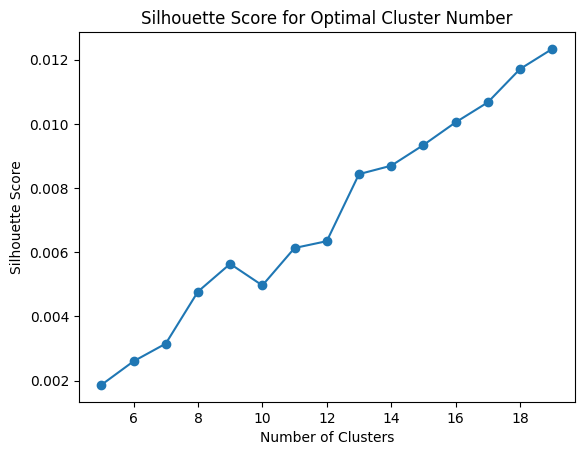

In [9]:
plt.plot(range(5, 20), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal Cluster Number")
plt.show()

In [10]:
# Clustering with KMeans
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
movies_summary['plot_structure_cluster'] = kmeans.fit_predict(combined_matrix)

In [11]:
movies_summary['plot_structure_cluster'].value_counts()

,count
plot_structure_cluster,
6,3744
1,1473
4,707
3,571
9,424
13,249
8,166
12,134
14,110


In [12]:
X_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0).fit_transform(combined_matrix)
X_reduced_pca = PCA(n_components=2).fit(combined_matrix).transform(combined_matrix)

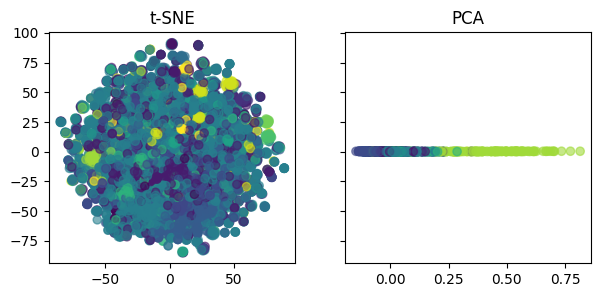

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)

# Cluster the data in 3 groups
labels = movies_summary['plot_structure_cluster']

# Plot the data reduced in 2d space with t-SNE
axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
axs[0].set_title("t-SNE")

# Plot the data reduced in 2d space with PCA
axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)
axs[1].set_title("PCA")

plt.show()

The **distribution of plot summaries across clusters** shows that the clustering algorithm has created some clusters with a significantly higher number of summaries than others. The top three clusters (2, 10, and 7) collectively hold a large portion of the summaries, indicating that certain plot structures may be more common. We have to dive more in the clusters.

**Top Terms per Cluster**

To gain a better understanding of each cluster's underlying plot structure, we examine the **top terms** associated with each cluster. By averaging the **TF-IDF values** of terms within each cluster, we identify the 10 most representative words for each group. This allows us to interpret the clusters.

In [14]:
# Cluster Interpretation
# Get the top terms per cluster by averaging the TF-IDF values of the terms in each cluster
terms = tfidf_vectorizer.get_feature_names_out()
cluster_centers = kmeans.cluster_centers_
top_terms_per_cluster = []

for i in range(n_clusters):
    top_terms_idx = cluster_centers[i].argsort()[-10:]  # Top 10 terms per cluster
    top_terms_per_cluster.append([terms[idx] for idx in top_terms_idx])

# Display top terms per cluster for interpretation
for i, terms in enumerate(top_terms_per_cluster):
    print(f"Cluster {i+1} top terms: {', '.join(terms)}")



Cluster 1 top terms: speed, money, father, car, win, billy, cole, horse, kid, race
Cluster 2 top terms: killed, killer, kill, house, gang, murder, man, car, frank, police
Cluster 3 top terms: adam, friend, home, new, wife, alex, elizabeth, beth, kate, nick
Cluster 4 top terms: space, captain, island, planet, bond, dr, alien, crew, earth, ship
Cluster 5 top terms: camp, japanese, american, battle, general, men, soldiers, army, king, war
Cluster 6 top terms: hank, gwen, money, family, nell, new, charlie, sal, eva, eddie
Cluster 7 top terms: man, home, young, new, life, love, mother, family, father, film
Cluster 8 top terms: ed, film, father, charlie, love, new, charley, lee, jerry, alice
Cluster 9 top terms: wife, life, family, new, elizabeth, house, mother, father, mary, john
Cluster 10 top terms: student, football, players, teacher, coach, students, high, game, team, school
Cluster 11 top terms: curse, vincent, father, bobby, life, money, man, kevin, kate, max
Cluster 12 top terms: chr

### Interpretation of Cluster Themes

Here’s an interpretation of each cluster based on the top terms:

- **Cluster 1**: Plots focused on competitive themes.
- **Cluster 2**: Crime or thriller themes, involving murder, gangs, and police confrontations.
- **Cluster 3**: Domestic and family-centered stories.
- **Cluster 4**: Sci-fi or adventure narratives set in space or otherworldly environments.
- **Cluster 5**: War or historical battle narratives, with themes of patriotism, loyalty, and military conflict.
- **Cluster 6**: Family dynamics involving financial or personal struggles, often with a focus on character growth.
- **Cluster 7**: Stories focused on love, personal growth, and the journey of family relationships.
- **Cluster 8**: Character-driven drama with themes of love, relationships, and family life.
- **Cluster 9**: Domestic dramas with family relationships at the center, often involving parents, spouses, and home life.
- **Cluster 10**: School or sports settings, focusing on themes of teamwork, mentorship, and competition.
- **Cluster 11**: Plots involving curses or superstitions, with an emphasis on individual struggles with fate or financial issues.
- **Cluster 12**: Family and relationship-centered stories, possibly featuring complex dynamics within close-knit communities.
- **Cluster 13**: Family-focused narratives often with themes of life challenges, father-son relationships, or personal introspection.
- **Cluster 14**: Stories about family dynamics and personal relationships, with a recurring theme of domestic settings.
- **Cluster 15**: Family-centered dramas, often highlighting parent-child dynamics and personal development.


Each cluster reveals distinct themes and settings. While this analysis helps to identify common elements within each group, **we are not fully satisfied with this approach** as it appears to capture **genre and themes more than specific plot structures**.

Since our goal is to identify different types of plot structures, clustering based solely on keywords may lack the depth needed to capture narrative progression and plot dynamics. Consequently, we explore alternative methods, such as leveraging large language models or deeper natural language processing techniques, to classify plot structures more accurately.

# **2. Large Language Model (LLM) Classification**

In this section, we employ LLMs to classify plot summaries into specific plot structure categories.

Given that 75% of the summaries exceed 713 words, they often surpass typical model token limits (1024 tokens). To address this, we first summarize long plot summaries using `facebook/bart-large-cnn`, reducing their length.

Once the summaries are manageable in size, we classify each summary using a zero-shot classification pipeline (`facebook/bart-large-mnli`). This approach allows us to categorize the plot structures without additional training, leveraging the model’s pre-trained capabilities for reliable categorization.

In [ ]:
# print stats about len of summaries
print(movies_summary['plot_summary'].apply(lambda x: len(x.split())).describe())

3515
count    8486.000000
mean      495.188310
std       351.862229
min        13.000000
25%       185.000000
50%       476.000000
75%       713.000000
max      3515.000000
Name: clean_plot_summary, dtype: float64


## 2.1 Summarization

In [ ]:
# We create the pipeline for summarization
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
def summarize_text(text):
    """
    Summarizes a plot summary if it exceeds a specified word count limit.

    This function leverages `facebook/bart-large-cnn` for summarization, handling lengthy plot summaries by dividing
    them into chunks when they exceed a set word count threshold. Each chunk is summarized separately, and the resulting
    summaries are concatenated to create a final, shorter version of the plot summary.

    Args:
        text (str): The input plot summary text to be summarized.

    Returns:
        str: The summarized text if the original text length exceeds the limit; otherwise, returns the original text.

    Logic:
        1. **Limit Check**: If the text's word count is below `limit` (600 words), the function returns the original text.
        2. **Chunking and Summarization**:
            - If the text exceeds `chunk_size` (700 words), it is divided into chunks of `chunk_size` words.
            - A 20-word overlap is added to the start of each subsequent chunk (except the first) to preserve context.
            - Each chunk is summarized individually.
            - The summaries of all chunks are concatenated to produce the final summary.
        3. **Single-Summary for Moderate-Length Texts**: If the text is above `limit` but under `chunk_size`, it is summarized
           directly without chunking.
    """

    limit=600
    chunk_size=700
    max_len=500
    min_len=300
    word_count = len(text.split())
    print("len text", len(text))
    print("word_count ", word_count)
    #print(text.split())
    if word_count < limit:
        return text
    if word_count > chunk_size :
      summary = ''
      for i in range(0, word_count, chunk_size):
        start = 20 if i == 0 else i
        end = min(i + chunk_size, word_count)
        print(i, start - 20, end)
        chunk = " ".join(text.split()[start-20:end])
        print("chunk :", chunk)
        chunk_len = len(chunk.split())
        if chunk_len < 250:
          summary += chunk
        else:
          summary += summarizer(chunk, max_length=450, min_length=min_len, do_sample=False)[0]['summary_text']
        print(summary)
      return summary

    summary = summarizer(text, max_length=max_len, min_length=min_len, do_sample=False)[0]['summary_text']
    return summary

In [ ]:
movies_summary['summarized'] = movies_summary['plot_summary'].apply(summarize_text)

## 2.2 Zero-shot Classification

Here we create our pipeline for classification, and classify our summarized plot summaries into plot structure categories. The plot structure categories were found using GPT4o.

In [ ]:
# We create the classification pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# Function to classify each plot summary
def classify_summary(summary):
    """
    Classifies a plot summary into a predefined set of plot structure categories using a zero-shot classification model.

    This function leverages a zero-shot classifier to categorize each plot summary into one of 15 distinct narrative
    structures.

    Args:
        summary (str): The plot summary to classify.

    Returns:
        str: The most likely plot structure category based on the model's classification.

    Notes:
        - The zero-shot classification model is pre-trained to handle tasks without additional training, leveraging its
          existing knowledge to map text to candidate categories.

    """
    candidate_labels = [
    "Hero’s Journey and Transformation: The protagonist undergoes personal growth, often starting as an ordinary individual who faces challenges, gains allies, overcomes obstacles, and returns transformed.",
    "Quest for Vengeance or Justice: A revenge-driven plot where the protagonist seeks retribution or justice for a past wrong or injustice.",
    "Coming of Age and Self-Discovery: The protagonist matures or gains self-awareness, often overcoming personal or societal obstacles.",
    "Survival or Escape: The story revolves around characters trying to survive dangerous situations or escape captivity.",
    "Rise and Fall of a Protagonist: The protagonist experiences a rise to power or success, followed by a tragic or inevitable downfall.",
    "Love and Relationship Dynamics: Focuses on romantic or family relationships, often dealing with misunderstandings, unions, reconciliations, or unfulfilled love.",
    "Comedy of Errors or Misadventure: Characters experience humorous, unintended consequences or misadventures while pursuing a goal.",
    "Crime and Underworld Exploration: The story explores criminal activities or the underworld, often involving heists, gang conflicts, or undercover missions.",
    "Power Struggle and Betrayal: Focuses on conflicts for power or leadership, with betrayal as a central theme, often involving shifting alliances.",
    "Mystery and Conspiracy Unveiling: The protagonist uncovers a hidden conspiracy, solves puzzles, or discovers hidden truths.",
    "Tragedy and Inevitability: A character-driven plot where the protagonist faces an inevitable negative outcome, often due to a flaw or external betrayal.",
    "Conflict with Supernatural or Unknown Forces: The protagonist encounters supernatural entities, unknown forces, or sci-fi elements that pose existential challenges.",
    "Comedy in Domestic Life: Focuses on the humor and challenges of family life, with everyday misunderstandings and domestic issues driving the plot.",
    "Social Rebellion or Fight Against Oppression: The protagonist challenges societal norms or oppressive systems, leading to personal or collective change.",
    "Fantasy or Science Fiction Quest: Centers on a journey or quest in a fantastical or sci-fi setting, involving world-building, encounters with non-human entities, and mythical or technological challenges."
  ]

    input_prompt = summary
    response = classifier(input_prompt, candidate_labels)
    classification = response['labels'][0]
    return classification


We then classify each plot summary's structure in batches, allowing us to handle large datasets more efficiently and prevent potential memory issues. We set a `batch_size` of 500 and use parallel processing to classify summaries within each batch concurrently. After processing each batch, we save the results to a CSV file as a checkpoint.

In [ ]:
movies_summary['summarized'] = movies_summary['summarized'].apply(classify_summary)

batch_size = 500
output_dir = '../data/classified_summaries_batches'
os.makedirs(output_dir, exist_ok=True)

for i in range(0, len(movies_summary), batch_size):
    batch = movies_summary.iloc[i:i + batch_size].copy()  # Work with a copy to avoid modifying the original DataFrame

    # Parallel processing of classification within the batch
    batch['plot_structure'] = Parallel(n_jobs=4)(delayed(classify_summary)(summary) for summary in batch['summarized'])

    # Save the processed batch to a CSV file as a checkpoint
    batch.to_csv(f"{output_dir}/classified_summaries_batch_{i}.csv", index=False)

In [ ]:
# We combine all batch files into a single file
all_batches = [pd.read_csv(f"{output_dir}/classified_summaries_batch_{i}.csv") for i in range(0, len(movies_summary), batch_size)]
classified_summaries = pd.concat(all_batches, ignore_index=True)
dir = '../data/processed'
os.makedirs(dir, exist_ok=True)
classified_summaries.to_csv('../data/processed/classified_summaries_with_plot_structures.csv', index=False)

## 2.3 Try classification with different categories


In [ ]:
# Function to classify each plot summary
def classify_summary_different_labels(summary):
    """
    Classifies a plot summary into a predefined set of plot structure categories using a zero-shot classification model.

    This function leverages a zero-shot classifier to categorize each plot summary into one of 15 distinct narrative
    structures.

    Args:
        summary (str): The plot summary to classify.

    Returns:
        str: The most likely plot structure category based on the model's classification.

    Notes:
        - The zero-shot classification model is pre-trained to handle tasks without additional training, leveraging its
          existing knowledge to map text to candidate categories.

    """
    candidate_labels = ['Relentless Pursuit: The protagonist is continuously pursued by a formidable opponent or authority, ending in a final showdown or escape.',
 'Memory Recovery: The protagonist suffers from memory loss and gradually uncovers their past identity and purpose, often leading to a significant revelation or reunion.',
 'Inheritance of Duty: A character inherits an extraordinary responsibility, skill, or artifact, which they must protect or learn to wield, typically involving rigorous challenges.',
 'Ordinary to Extraordinary Journey: An unsuspecting character is drawn into an epic journey, evolving through obstacles to fulfill a unique role they initially resisted or doubted.',
 'Countdown Crisis: Characters face a strict deadline, solving complex problems or overcoming obstacles before time runs out to avert disaster.',
 'High-Stakes Rescue: The plot centers on rescuing a person or group from peril, often requiring the protagonist to confront significant physical or moral dilemmas.',
 'Breakout Plot: The protagonist begins in captivity and must plan and execute an escape, often by navigating complex social or environmental challenges.',
 'Amnesiac Reunion: Following separation and loss of memory, characters are reunited after a series of incidental encounters gradually restore memories.',
 'Redemption Arc: A flawed or once-villainous character seeks redemption, confronting their past through sacrifice or atonement.',
 'Hidden Power Awakening: A character discovers hidden abilities and must undergo training, typically to prepare for a unique challenge or mission.',
 'Unlikely Alliance: Disparate characters join forces to achieve a shared goal, learning to overcome differences and trust each other to succeed.',
 'Revolutionary Uprising: The protagonist and allies challenge an oppressive authority, with the story leading to a climactic confrontation or overthrow.',
 'Guardian Mission: The protagonist is tasked with safeguarding a vulnerable individual, group, or object, navigating multiple threats to fulfill their protective role.',
 'Duel for Justice: The storyline builds toward a climactic one-on-one duel, often against a personal nemesis, to settle a longstanding score or defend a cause.',
 'Treasure Hunt: Characters compete to uncover a coveted object or location, leading to rivalries, alliances, and betrayals along the way.',
 'Mistaken Identity Spiral: A character is misidentified or assumed to be someone else, resulting in escalating misunderstandings they must unravel.',
 'Rise to Downfall: The protagonist rises to prominence but faces a dramatic fall, often due to personal flaws or betrayal, leading to a period of reckoning.',
 'Parallel Journeys: Two main characters embark on distinct but intersecting journeys, with their paths influencing each other toward a shared conclusion.',
 'Mission to Save a Community: The protagonist works to save or uplift their community from a specific threat, often gaining respect or unity along the way.',
 'Discovery Expedition: A journey or exploration driven by curiosity or necessity, uncovering significant discoveries or secrets that impact the characters or world.',
 'Comedy of Errors or Misadventure: Characters experience humorous, unintended consequences or misadventures while pursuing a goal.',
  'Fantasy or Science Fiction Quest: Journey in a fantastical or sci-fi setting.',
  'Survival or Escape: The story revolves around characters trying to survive dangerous situations or escape captivity.']

    input_prompt = summary
    response = classifier(input_prompt, candidate_labels)
    classification = response['labels'][0]
    return classification


In [ ]:
movies_summary['summarized'] = movies_summary['summarized'].apply(classify_summary_different_labels)

batch_size = 500
output_dir = '../data/classified_summaries_batches_second_labels'
os.makedirs(output_dir, exist_ok=True)

for i in range(0, len(movies_summary), batch_size):
    batch = movies_summary.iloc[i:i + batch_size].copy()  # Work with a copy to avoid modifying the original DataFrame

    # Parallel processing of classification within the batch
    batch['plot_structure'] = Parallel(n_jobs=4)(delayed(classify_summary)(summary) for summary in batch['summarized'])

    # Save the processed batch to a CSV file as a checkpoint
    batch.to_csv(f"{output_dir}/classified_summaries_batch_{i}.csv", index=False)

In [ ]:
# We combine all batch files into a single file
all_batches = [pd.read_csv(f"{output_dir}/classified_summaries_batch_{i}.csv") for i in range(0, len(movies_summary), batch_size)]
classified_summaries = pd.concat(all_batches, ignore_index=True)
classified_summaries.to_csv('../data/processed/classified_summaries_with_plot_structures_second_labels.csv', index=False)